In [18]:
import typing
import lzma
import os
import dataclasses
import itertools
import functools
from importlib import reload
from pathlib import Path
from types import MappingProxyType, SimpleNamespace

import cbor2
import attrs
import tqdm.auto
import jax
import jax.numpy as jnp
from flax import nnx
import optax
import jaxtyping as jt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from arc25 import symmetry, tools as arc25_tools
from arc25.symmetry import D4, transform_vector
from arc25 import serialisation
from arc25.dsl.types import Vector, Dir4
from arc25.vision2.symrep import SymDecompBase, SplitSymDecomp, SymDecompDims, standard_rep, RepSpec
from arc25.vision2.fields import FieldDims, CoordinateGrid
from arc25.vision2.linear import SpaceSymmetricLinear, SpaceSymmetricTensor, SymmetryMappingSpec, SymDecompLinear
from arc25.vision2 import fields, attention, encoder, transformer, mae, swiglu
from arc25.training import saving, dataset, mae as mae_trainer, knn_eval, linear_probe

In [2]:
proj_root = Path("..").resolve()
data_root = proj_root / "data"

In [5]:
all_ds = await Dataset.from_binary(data_root/"repack/all-challenges.cbor.xz")

In [17]:
all_ds.subsets
for subset,chals in all_ds.subsets.items():
    equal_shape = []
    for c in chals:
        c = all_ds.challenges[c]
        all_equal = all(iop.input.shape == iop.output.shape for iop in c.train)
        equal_shape.append(all_equal)
    print(f"{subset:20s}: {int(np.sum(equal_shape)):4d}/{len(equal_shape):4d} have equal shape")
        

concept-arc         :  119/ 160 have equal shape
arc-agi-1.evaluation:  270/ 400 have equal shape
arc-agi-1.training  :  262/ 400 have equal shape
arc-agi-2.evaluation:   81/ 120 have equal shape
arc-agi-2.training  :  680/1000 have equal shape
larc                :  262/ 400 have equal shape
harc.evaluation     :  270/ 400 have equal shape
harc.training       :  262/ 400 have equal shape
arc-agi-1           :  532/ 800 have equal shape
arc-agi-2           :  761/1120 have equal shape
harc                :  532/ 800 have equal shape
all                 :  902/1307 have equal shape


At base cost 64, minibatch size should be 59.8
At base cost 64, minibatch size should be 14.2


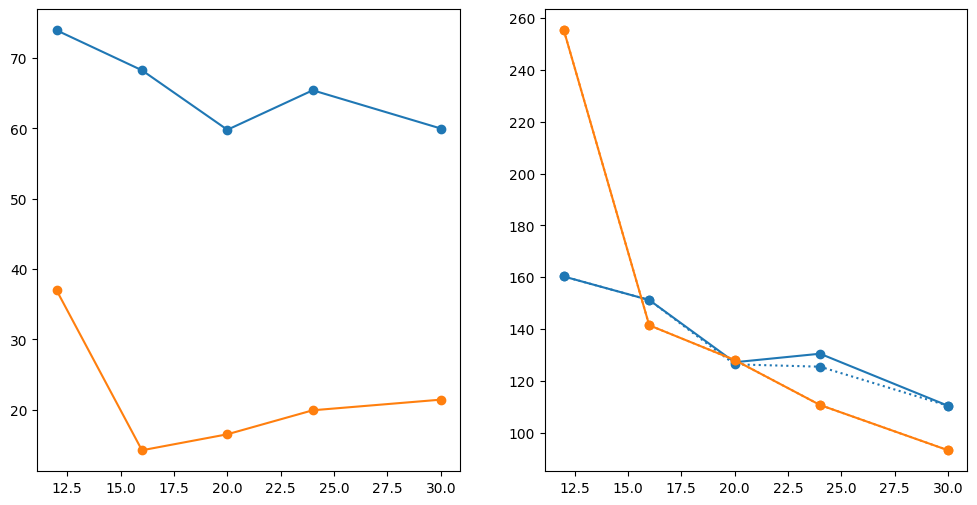

In [84]:
v6e = np.r_[
    30,14, 5.46,14, 5.46,
    24,20, 8.07,23, 7.76,
    20,24, 9.44,29, 9.38,
    16,48,14.03,48,14.03,
    12,80,19.83,80,19.83,
].reshape(-1,5)

L4 = np.r_[
    30, 5, 1.63, 5, 1.63,
    24, 7, 2.42, 7, 2.42,
    20, 8, 3.36, 8, 3.36,
    16,10, 4.64,10, 4.64,
    12,40,11.17,40,11.17,
].reshape(-1,5)


fig, axes = plt.subplots(1,2,figsize=(12,6),sharex=True)
for v,cost,ccb in zip([v6e,L4],[2.97,1.05],[64,64]):
    imsz, fsz, fspd, bsz, bspd = v.T
    ax = axes[0]
    memory = (imsz**2 + ccb) / 15**2
    print(f"At base cost {ccb}, minibatch size should be {(bsz*memory).min():.1f}")
    l, = ax.plot(imsz, bsz*memory,'o-')
    c = l.get_color()
    #memory = 7*imsz*((imsz+7)//8) / 15**2
    #ax.plot(imsz, bsz*memory,'o:',c=c)
    ax = axes[1]
    work = imsz*(imsz-0)
    weight = 0.5*imsz
    fac = work/weight/cost
    ax.plot(imsz, fspd*fac,'o-',c=c)
    ax.plot(imsz, bspd*fac,'o:',c=c)